In [3]:
import pandas as pd
import numpy as np
import itertools
from itertools import permutations
import statistics

df = pd.read_csv('/Users/pingchuanma/Desktop/ChenLab_Data/RvR/New_RvR_analysis/Raw_csv_files_no1627/Scatter Plot (Raw)_grouped_no1627_20230115.csv', 
                 converters={'Speed': lambda x: 'Running' if float(x)>0 else 'Resting'})
mice = np.sort(df['Mouse ID'].unique())
laserPowers = np.sort(df['Laser'].unique())
groups = list(itertools.product(mice, laserPowers))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/pingchuanma/Desktop/ChenLab_Data/RvR/New_RvR_analysis/Raw_csv_files_no1627/Scatter Plot (Raw)_grouped_no1627_20230115.csv'

In [2]:
states = df['Speed'].unique()
features = ['Fit Lifetime', 'Empirical Lifetime', 'Intensity']

featureCombinations = list(itertools.product(states, features))
columns = [str[0]+ ' ' +str[1] for str in featureCombinations]
print(featureCombinations)

keys = ['Mouse ID', 'Laser'] + columns
summary = {key:[] for key in keys}


for group in groups:
    summary['Mouse ID'].append(group[0])
    summary['Laser'].append(group[1])
    for featureSet in featureCombinations:
        rows = df.loc[(df['Mouse ID'] == group[0]) & (df['Laser'] == group[1]) & (df['Speed'] == featureSet[0])]
        try:
            summary[columns[featureCombinations.index(featureSet)]].append(statistics.mean(rows[featureSet[1]]))
        except:
            summary[columns[featureCombinations.index(featureSet)]].append(np.nan)
            
outputDF = pd.DataFrame(summary)
outputDF.to_csv('RvR_Aggregated.csv')

NameError: name 'df' is not defined

Mouse ID: 1610


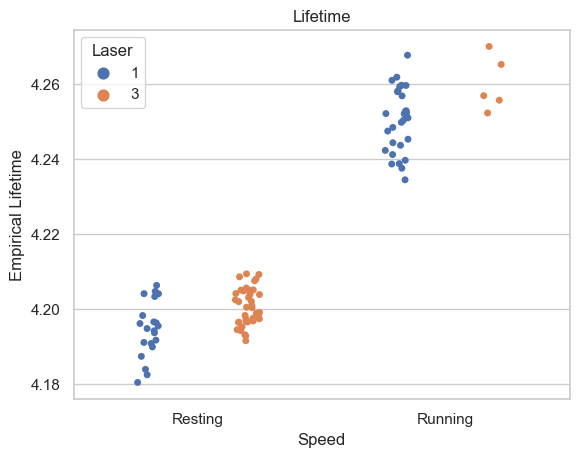

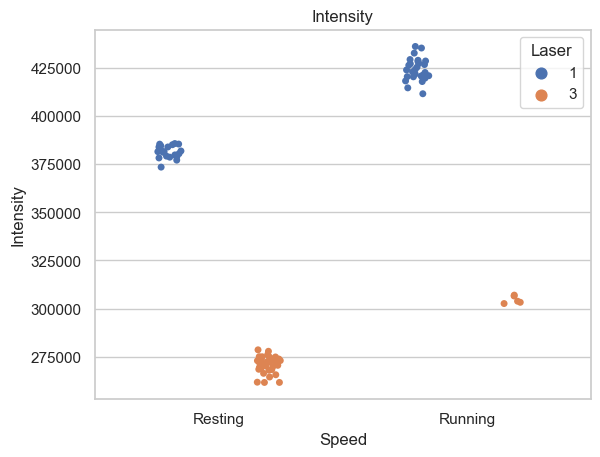

Mouse ID: 1611


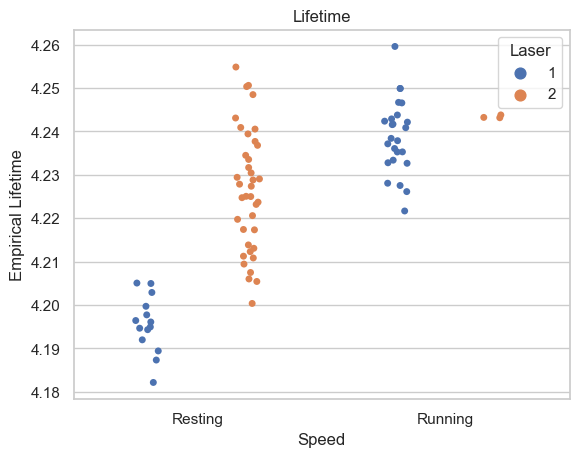

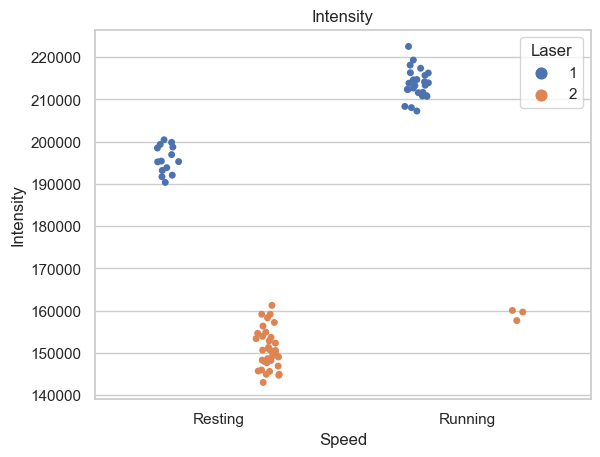

Mouse ID: 1612


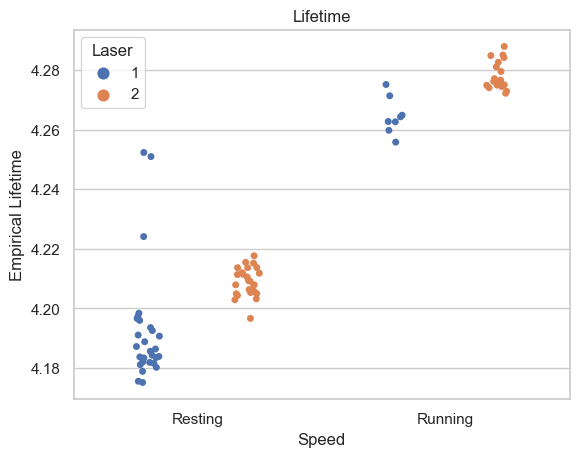

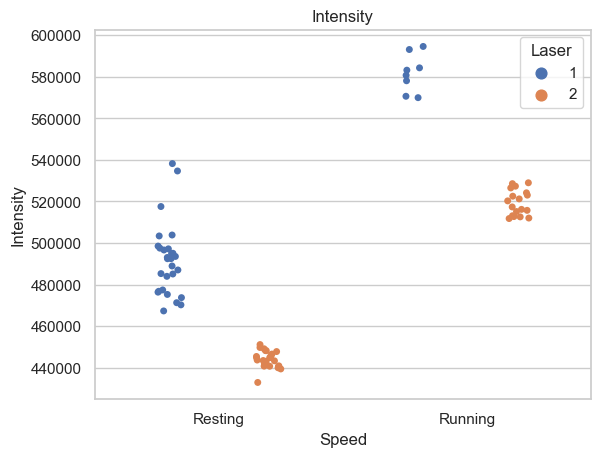

Mouse ID: 1626


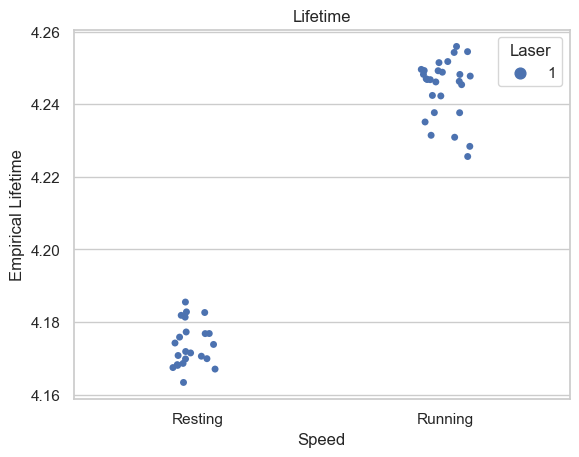

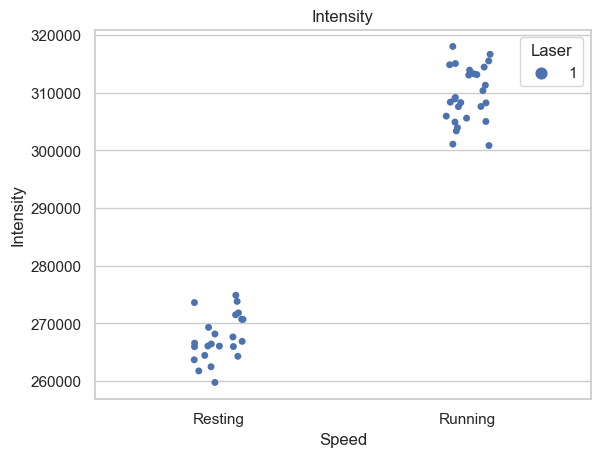

Mouse ID: 1629


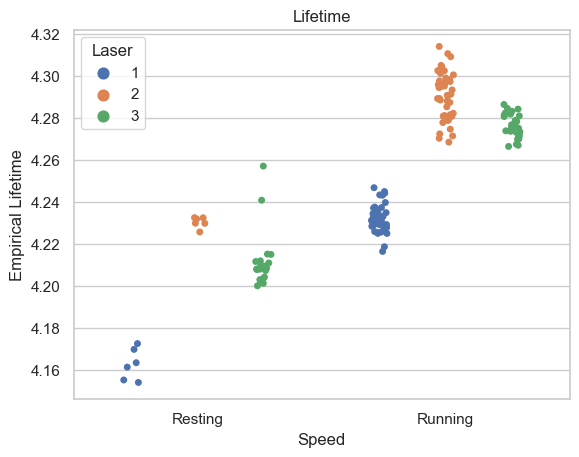

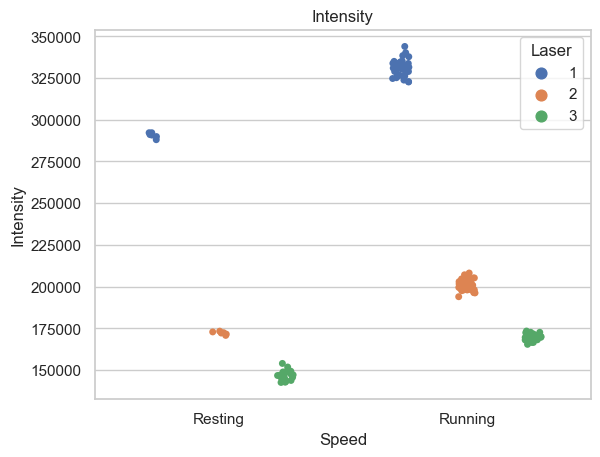

Mouse ID: 1630


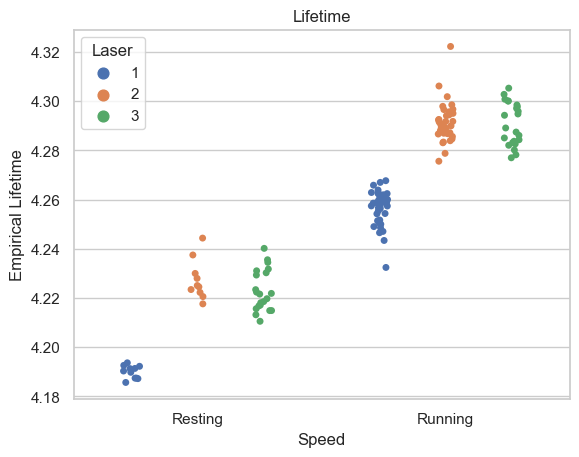

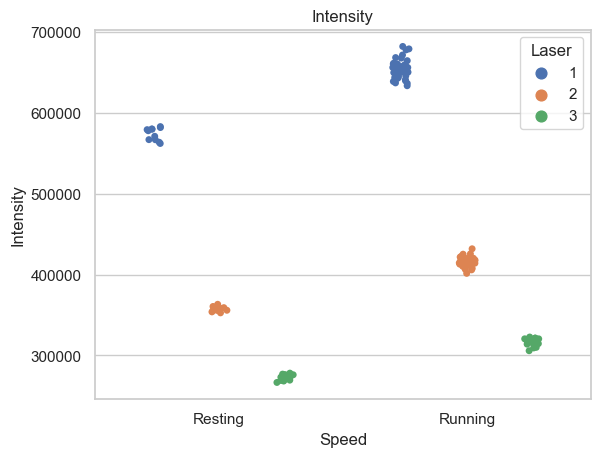

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

#Scatter Plots by Mouse
for mouse in mice:
    print('Mouse ID: ' + str(mouse))
    rows = df.loc[(df['Mouse ID'] == mouse)]
    
    sns.set(style = 'whitegrid')      
    sns.stripplot(x="Speed", y="Empirical Lifetime", data=rows, hue = 'Laser', dodge = True)
    plt.title('Lifetime')
    plt.show()
    sns.stripplot(x="Speed", y="Intensity", data=rows, hue = 'Laser', dodge = True)
    plt.title('Intensity')
    plt.show()

Laser Power: 1


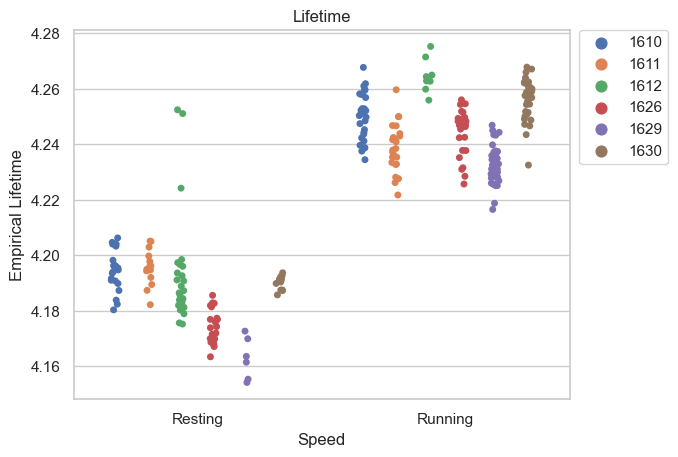

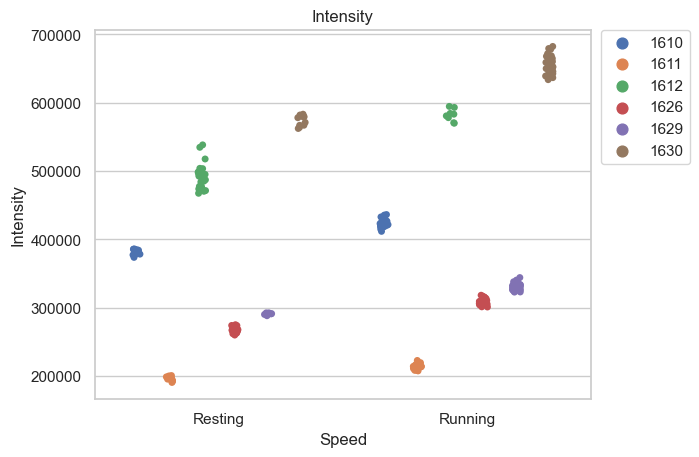

Laser Power: 2


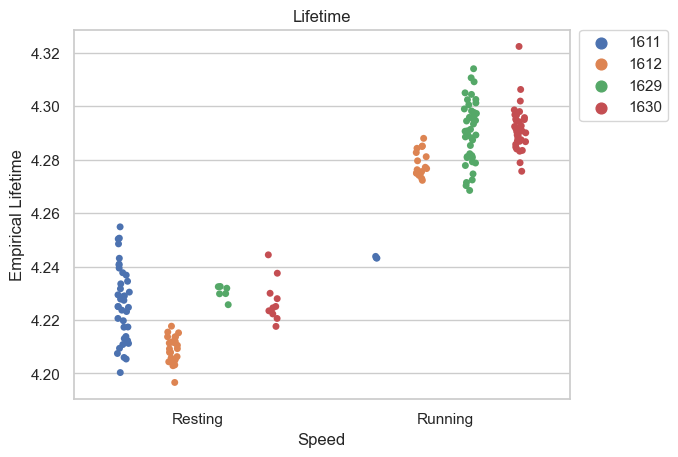

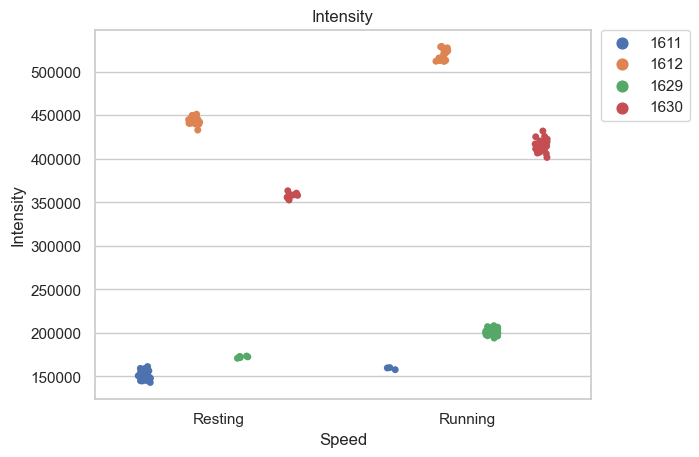

Laser Power: 3


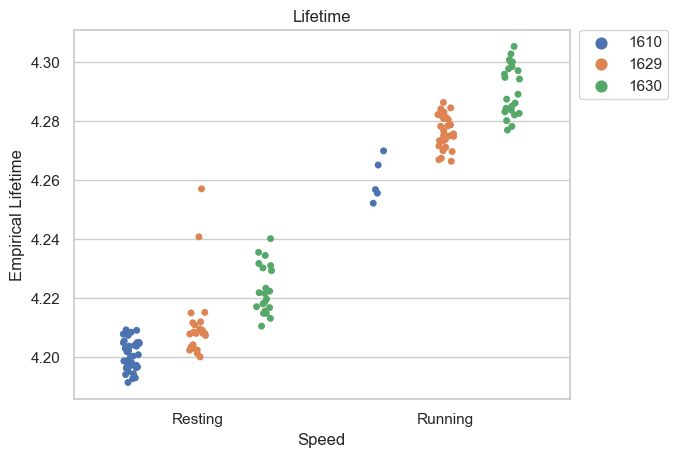

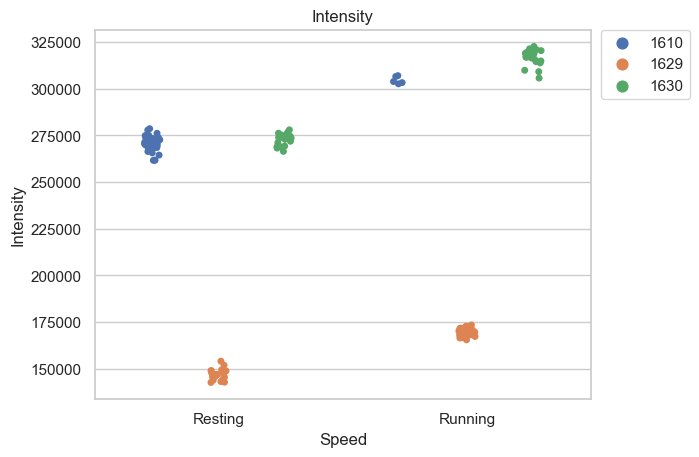

In [4]:
#Scatter Plots by Laser
for laser in laserPowers:
    print('Laser Power: ' + str(laser))
    rows = df.loc[(df['Laser'] == laser)]
    
    sns.set(style = 'whitegrid')      
    sns.stripplot(x="Speed", y="Empirical Lifetime", data=rows, hue = 'Mouse ID', dodge = True)
    plt.title('Lifetime')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    sns.stripplot(x="Speed", y="Intensity", data=rows, hue = 'Mouse ID', dodge = True)
    plt.title('Intensity')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
            

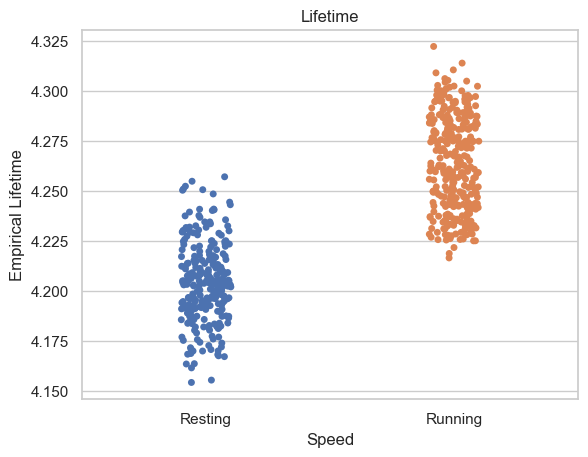

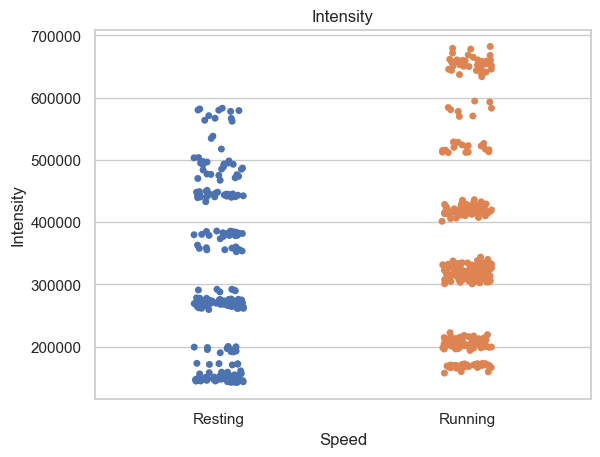

In [5]:
#All Grouped

sns.set(style = 'whitegrid')      
sns.stripplot(x="Speed", y="Empirical Lifetime", data=df, dodge = True)
plt.title('Lifetime')
plt.show()

sns.stripplot(x="Speed", y="Intensity", data=df, dodge = True)
plt.title('Intensity')
plt.show()

In [30]:
# RFE linear regression (OLS) incremental r^2
# integer encoding of categorical predictors

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm


def integer_encoding(df, cols, centered = True):
    print('Encoding:')
    for col in cols:
        #create bins
        uniqueValues = np.sort(df[col].unique())
        if (centered == True) and len(uniqueValues) % 2 == 1:
            integer_bins = [*range(-(len(uniqueValues)//2),(len(uniqueValues)//2)+1)]
        elif (centered == True) and len(uniqueValues) % 2 == 0:
            integer_bins = [*range(-(len(uniqueValues)//2),0)]+[*range(1,(len(uniqueValues)//2)+1)]
        else:
            integer_bins = [*range(len(uniqueValues))]
            
        integer_dict = {val: integer_bins[list(uniqueValues).index(val)] for val in uniqueValues}

        df[col] = df[col].replace(integer_dict)
        print(integer_dict)
    return df

def linear_RFE(X, y):
    rfe = RFE(LinearRegression(), importance_getter='auto')
    rfe = rfe.fit(X, y)
    rfe_ranking = [x for _, x in sorted(zip(rfe.ranking_, X.columns))]
    print('\nRFE Order:')
    print(rfe_ranking)
    return rfe_ranking

def linear_RFE_dummy(X, y):
    rfe = RFE(LinearRegression(), importance_getter='auto')
    rfe = rfe.fit(X_dummy, y)
    rfe_ranking = [x for _, x in sorted(zip(rfe.ranking_, X_dummy.columns))]
    print('\nRFE Order:')
    print(rfe_ranking)
    return rfe_ranking

def incremental_rSquared(X, y, featureRank, adjusted = True):
    print('\nIncremental R Squared:')
    increments = []
    rSquared = []
    rSquared_adjusted = []
    for feature in range(len(featureRank)):
        
        X_temp = X[featureRank[0:feature+1]].copy()
        model = LinearRegression()
        model.fit(X_temp, y)
        r_squared, adjusted_r_squared = calculate_rSquared(model, X_temp, y)
        
        rSquared.append(r_squared)
        rSquared_adjusted.append(adjusted_r_squared)
        
        if adjusted:
            increments.append(adjusted_r_squared-sum(increments))
        else:
            increments.append(r_squared-sum(increments))
    contribution = {featureRank[idx]:increments[idx]/rSquared[-1] for idx in range(len(increments))}
    return contribution, rSquared, rSquared_adjusted


def calculate_rSquared(model, X, y):
#     yhat = model.predict(X)
#     SS_Residual = sum((y-yhat)**2)       
#     SS_Total = sum((y-np.mean(y))**2)     
#     r_squared = 1 - (float(SS_Residual))/SS_Total
    r_squared = model.score(X,y)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return r_squared, adjusted_r_squared



In [7]:
# RVR Data
# RFE linear regression (OLS) incremental r^2
# integer encoding of categorical predictors

df_categorical = df.copy(deep=True)
df_categorical = integer_encoding(df_categorical, ['Mouse ID', 'Speed', 'Laser'])

print('\n\nIntensity Data')
X = df_categorical.drop(['Intensity', 'Fit Lifetime', 'Empirical Lifetime', 'Dataset'], axis=1)
y = df_categorical['Intensity']

featureRank = linear_RFE(X, y)

contribution, r_squared, adjusted_r_squared = incremental_rSquared(X, y, featureRank)
print('\nR^2 Values:')
print(r_squared)
print('\nAdjusted R^2 Values:')
print(adjusted_r_squared)
print('\nContribution:')
print(contribution)


print('\n\nLifetime Data')

y = df_categorical['Empirical Lifetime']

featureRank = linear_RFE(X, y)

contribution, r_squared, adjusted_r_squared = incremental_rSquared(X, y, featureRank)
print('\nR^2 Values:')
print(r_squared)
print('\nAdjusted R^2 Values:')
print(adjusted_r_squared)
print('\nContribution:')
print(contribution)

Encoding:
{1610: -3, 1611: -2, 1612: -1, 1626: 1, 1629: 2, 1630: 3}
{'Resting': -1, 'Running': 1}
{1: -1, 2: 0, 3: 1}


Intensity Data

RFE Order:
['Laser', 'Mouse ID', 'Speed']

Incremental R Squared:

R^2 Values:
[0.21347583144226578, 0.24838845021952516, 0.25186017908166314]

Adjusted R^2 Values:
[0.21213592655545543, 0.24582322308716864, 0.2480235646154153]

Contribution:
{'Laser': 0.842276565231348, 'Mouse ID': 0.13375396084662688, 'Speed': 0.008736361326628075}


Lifetime Data

RFE Order:
['Speed', 'Laser', 'Mouse ID']

Incremental R Squared:

R^2 Values:
[0.6557256597946473, 0.7846808009031141, 0.7904370746133378]

Adjusted R^2 Values:
[0.6551391617704474, 0.7839459230904967, 0.7893623929446882]

Contribution:
{'Speed': 0.8288315196891862, 'Laser': 0.16295637623407072, 'Mouse ID': 0.006852499747486076}


In [8]:
#RvR Data
#Logistic regression to find pseudo R^2 for using Intensity/Lifetime to predict State

import statsmodels.formula.api as smf

df_categorical['emp_lft'] = df_categorical['Empirical Lifetime'].copy()
df_categorical['Speed_binary'] = df_categorical['Speed'].copy()
df_categorical['Speed_binary'] = [0 if point == -1 else 1 for point in df_categorical['Speed_binary']]

print('Intensity')    
log_reg = smf.logit('Speed_binary ~ Intensity', data = df_categorical).fit()
print(log_reg.summary())

print('Lifetime')    
log_reg = smf.logit('Speed_binary ~ emp_lft', data = df_categorical).fit()
print(log_reg.summary())

Intensity
Optimization terminated successfully.
         Current function value: 0.668864
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           Speed_binary   No. Observations:                  589
Model:                          Logit   Df Residuals:                      587
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Jan 2023   Pseudo R-squ.:                 0.02750
Time:                        23:51:11   Log-Likelihood:                -393.96
converged:                       True   LL-Null:                       -405.10
Covariance Type:            nonrobust   LLR p-value:                 2.361e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7128      0.215     -3.314      0.001      -1.134      -0.291
Intensity   2.807e-

In [8]:
# Sleep Data
# RFE linear regression (OLS) incremental r^2
# integer encoding of categorical predictors


df_sleep = pd.read_csv('/Users/pingchuanma/Documents/MATLAB/Publication/Fluorescence lifetim enables high-resolution analysis of neuromodulator dynamics across time and animals/Pingchuan_SW_data_code/sleep_wake_all_table.csv')
df_sleep_categorical = integer_encoding(df_sleep, ['Mouse_ID', 'Time', 'State'])

print('\n\nIntensity Data')
X = df_sleep_categorical.drop(['Intensity', 'Lifetime'], axis=1)

y = df_sleep_categorical['Intensity']

print(X)
featureRank = linear_RFE(X, y)
contribution, r_squared, adjusted_r_squared = incremental_rSquared(X, y, featureRank)
print('\nR^2 Values:')
print(r_squared)
print('\nAdjusted R^2 Values:')
print(adjusted_r_squared)
print('\nContribution:')
print(contribution)


print('\n\nLifetime Data')

y = df_sleep_categorical['Lifetime']

featureRank = linear_RFE(X, y)

contribution, r_squared, adjusted_r_squared = incremental_rSquared(X, y, featureRank)
print('\nR^2 Values:')
print(r_squared)
print('\nAdjusted R^2 Values:')
print(adjusted_r_squared)
print('\nContribution:')
print(contribution)

Encoding:
{1610: -3, 1611: -2, 1612: -1, 1626: 1, 1629: 2, 1630: 3}
{1: -1, 2: 0, 3: 1}
{2: -1, 3: 1}


Intensity Data
     Mouse_ID  Time  State
0          -3     0     -1
1          -3     0     -1
2          -3     0     -1
3          -3     0     -1
4          -3     0     -1
..        ...   ...    ...
622         3     1      1
623         3     1      1
624         3     1      1
625         3     1      1
626         3     1      1

[627 rows x 3 columns]

RFE Order:
['Time', 'Mouse_ID', 'State']

Incremental R Squared:

R^2 Values:
[0.2615263336325421, 0.2979291233636415, 0.3035211613073795]

Adjusted R^2 Values:
[0.2603447757663542, 0.29567889619493526, 0.30016733062346646]

Contribution:
{'Time': 0.8577483515315755, 'Mouse_ID': 0.1164140262128142, 'State': 0.014787879728707631}


Lifetime Data

RFE Order:
['State', 'Time', 'Mouse_ID']

Incremental R Squared:

R^2 Values:
[0.4629951939018402, 0.49457429240839257, 0.4968834625077244]

Adjusted R^2 Values:
[0.46213598621208307, 

In [31]:
# Sleep Data
# RFE linear regression (OLS) incremental r^2
# integer encoding of categorical predictors
from sklearn.preprocessing import OneHotEncoder

df_sleep = pd.read_csv('/Users/pingchuanma/Documents/MATLAB/Publication/Fluorescence lifetim enables high-resolution analysis of neuromodulator dynamics across time and animals/Pingchuan_SW_data_code/sleep_wake_all_table.csv')
df_sleep_categorical = integer_encoding(df_sleep, ['Mouse_ID', 'Time', 'State'])

print('\n\nIntensity Data')
X = df_sleep_categorical.drop(['Intensity', 'Lifetime'], axis=1)
y = df_sleep_categorical['Intensity']

X_dummy_mouse = pd.get_dummies(X['Mouse_ID'], prefix='mouse')
X_dummy_time = pd.get_dummies(X['Time'], prefix='time')
X_dummy_state = pd.get_dummies(X['State'], prefix='state')

print("dataset prit")
display(X_dummy_mouse)
display(X_dummy_time)
display(X_dummy_state)

X_dummy = pd.concat([X_dummy_mouse, X_dummy_time, X_dummy_state], axis = 1)
display(X_dummy)

X = X_dummy.copy()
print("Check")
display(X)
#print(X)
featureRank = linear_RFE_dummy(X, y)

contribution, r_squared, adjusted_r_squared = incremental_rSquared(X, y, featureRank)
print('\nR^2 Values:')
print(r_squared)
print('\nAdjusted R^2 Values:')
print(adjusted_r_squared)
print('\nContribution:')
print(contribution)


print('\n\nLifetime Data')

y = df_sleep_categorical['Lifetime']

featureRank = linear_RFE(X, y)

contribution, r_squared, adjusted_r_squared = incremental_rSquared(X, y, featureRank)
print('\nR^2 Values:')
print(r_squared)
print('\nAdjusted R^2 Values:')
print(adjusted_r_squared)
print('\nContribution:')
print(contribution)

Encoding:
{1610: -3, 1611: -2, 1612: -1, 1626: 1, 1629: 2, 1630: 3}
{1: -1, 2: 0, 3: 1}
{2: -1, 3: 1}


Intensity Data
dataset prit


,mouse_-3,mouse_-2,mouse_-1,mouse_1,mouse_2,mouse_3
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
622,0,0,0,0,0,1
623,0,0,0,0,0,1
624,0,0,0,0,0,1
625,0,0,0,0,0,1


,time_-1,time_0,time_1
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
622,0,0,1
623,0,0,1
624,0,0,1
625,0,0,1


,state_-1,state_1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
622,0,1
623,0,1
624,0,1
625,0,1


,mouse_-3,mouse_-2,mouse_-1,mouse_1,mouse_2,mouse_3,time_-1,time_0,time_1,state_-1,state_1
0,1,0,0,0,0,0,0,1,0,1,0
1,1,0,0,0,0,0,0,1,0,1,0
2,1,0,0,0,0,0,0,1,0,1,0
3,1,0,0,0,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
622,0,0,0,0,0,1,0,0,1,0,1
623,0,0,0,0,0,1,0,0,1,0,1
624,0,0,0,0,0,1,0,0,1,0,1
625,0,0,0,0,0,1,0,0,1,0,1


Check


,mouse_-3,mouse_-2,mouse_-1,mouse_1,mouse_2,mouse_3,time_-1,time_0,time_1,state_-1,state_1
0,1,0,0,0,0,0,0,1,0,1,0
1,1,0,0,0,0,0,0,1,0,1,0
2,1,0,0,0,0,0,0,1,0,1,0
3,1,0,0,0,0,0,0,1,0,1,0
4,1,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
622,0,0,0,0,0,1,0,0,1,0,1
623,0,0,0,0,0,1,0,0,1,0,1
624,0,0,0,0,0,1,0,0,1,0,1
625,0,0,0,0,0,1,0,0,1,0,1



RFE Order:
['mouse_-2', 'mouse_-3', 'mouse_1', 'mouse_2', 'mouse_3', 'mouse_-1', 'time_-1', 'time_0', 'time_1', 'state_1', 'state_-1']

Incremental R Squared:

R^2 Values:
[0.22178323553121992, 0.22181230173601796, 0.43555337837949004, 0.6543729681842971, 0.6641256565573741, 0.6639908429104187, 0.7813357240781471, 0.820330484880043, 0.8195829092179278, 0.830792197418506, 0.8306259608838321]

Adjusted R^2 Values:
[0.2205380887080699, 0.21931811039542826, 0.43283533686285836, 0.6521502863076689, 0.6614213542752274, 0.6607391413901968, 0.7788629455136027, 0.8180046659140889, 0.8169512174561147, 0.8280453175064687, 0.8275965065256567]

Contribution:
{'mouse_-2': 0.26550830228494804, 'mouse_-3': -0.0014687457051589389, 'mouse_1': 0.25705580673187234, 'mouse_2': 0.26403575107554705, 'mouse_3': 0.011161543708185534, 'mouse_-1': -0.0008213238174071177, 'time_-1': 0.14221058537312697, 'time_0': 0.04712316041607619, 'time_1': -0.0012682585274042656, 'state_1': 0.013356312675983919, 'state_-1': 

In [10]:
df_sleep_categorical['State_01'] = df_sleep_categorical['State'].copy()
df_sleep_categorical['State_01'] = [0 if point == -1 else 1 for point in df_sleep_categorical['State_01']]

print('Intensity')    
log_reg = smf.logit('State_01 ~ Intensity', data = df_sleep_categorical).fit()
print(log_reg.summary())

print('Lifetime')    
log_reg = smf.logit('State_01 ~ Lifetime', data = df_sleep_categorical).fit()
print(log_reg.summary())

Intensity
Optimization terminated successfully.
         Current function value: 0.602003
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               State_01   No. Observations:                  627
Model:                          Logit   Df Residuals:                      625
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Jan 2023   Pseudo R-squ.:                0.003000
Time:                        23:51:20   Log-Likelihood:                -377.46
converged:                       True   LL-Null:                       -378.59
Covariance Type:            nonrobust   LLR p-value:                    0.1318
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2037      0.229     -5.248      0.000      -1.653      -0.754
Intensity      0.12